confusion matrix :
    http://gcucurull.github.io/caffe/python/deep-learning/2016/06/29/caffe-confusion-matrix/
    https://github.com/gcucurull/caffe-conf-matrix
FCN :
    score :
        https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/score.py
    infer :
        https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/infer.py

In [1]:
from __future__ import division
from __future__ import print_function

import caffe
import numpy as np
import os
import sys
from datetime import datetime
from PIL import Image
from IPython.display import Image
from IPython.display import clear_output
import time
import _init_paths

import itertools

from matplotlib.pyplot import imshow
from matplotlib.pyplot import imread
from matplotlib.pyplot import imsave
%matplotlib inline

In [54]:
def plot_cm(conf_arr, classes,
            title='Confusion matrix',
            cmap=plt.cm.jet):
    #cmap=plt.cm.Blues
    norm_conf = []
    for i in conf_arr:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)

    fig = plt.figure(figsize = (8,8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                    interpolation='nearest')

    width, height = conf_arr.shape

    for x in xrange(width):
        for y in xrange(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')

    cb = fig.colorbar(res)
    plt.xticks(range(width), classes, rotation=45)
    plt.yticks(range(height), classes)
    plt.title(title)
    #plt.savefig('confusion_matrix.png', format='png')

In [98]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, notext=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if not notext:
            print("Normalized confusion matrix")
    else:
        if not notext:
            print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    
    if not notext:
        if normalize:
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, int(round(100*cm[i, j])),
                         horizontalalignment="center",
                         color="white" if cm[i, j] < thresh else "black")
        else:
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, cm[i, j],
                         horizontalalignment="center",
                         color="white" if cm[i, j] < thresh else "black")
                

    
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title(title)
        
    plt.tight_layout()

In [2]:
def log_progress(sequence, title='', every=1, size=None, end_msg='', removeAtTheEnd=False):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    if isinstance(sequence, dict):
                        val = ''
                    else:
                        val=sequence[index-1]
                            
                    label.value = u'{title} : {value} ({index} / {size})'.format(
                        title=title,
                        value=val,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = end_msg
        if removeAtTheEnd:
            box.close()

In [3]:
SHRECmodels = '/home/jguerry/workspace/SHRECmodels/'
# prototxt_path = SHRECmodels+'c14_kf3_var5_train_val.prototxt'
# weights_path =  SHRECmodels+'c14_kf3_var5.caffemodel'

# prototxt_path = SHRECmodels+'14bi28_kf5_var5 .prototxt'
# weights_path =  SHRECmodels+'14bi28_kf5_var5.caffemodel'

prototxt_path = SHRECmodels+'THEproto.prototxt'
weights_path =  SHRECmodels+'THEweights.caffemodel'

caffe_gpu = True
if not caffe_gpu:
    caffe.set_mode_cpu()
else:
    caffe.set_mode_gpu()
    caffe.set_device(0);

In [4]:
# net = caffe.Net(prototxt_path, caffe.TEST)
net = caffe.Net(prototxt_path, weights_path, caffe.TEST)

In [5]:
results={}
results['id_gesture']=[]
results['id_finger']=[]
results['id_subject']=[]
results['id_essai']=[]
results['label_gt']=[]
results['label_found']=[]
results['label_gt_28']=[]
results['label_found_28']=[]
results['time_millisecond']=[]
                     

In [6]:
print("###############################################################")

# net.layers[0].images_processed = 100

for idx in log_progress(range(net.layers[0].nb_images), title='iteration', end_msg='Finished !',removeAtTheEnd=True):
# for idx in log_progress(range(5), title='iteration', end_msg='Finished !',removeAtTheEnd=True):

    #print("Idx :",idx)
    t = time.time()
    net.forward()
    results['id_gesture'].append(int(net.layers[0].list_images[idx,0]))
    results['id_finger'].append(int(net.layers[0].list_images[idx,1]))
    results['id_subject'].append(int(net.layers[0].list_images[idx,2]))
    results['id_essai'].append(int(net.layers[0].list_images[idx,3]))
    results['label_gt'].append(int(net.blobs['label'].data[0]))
#     results['label_found'].append(int(net.blobs['fc_14'].data[0].argmax(0)))
    results['label_gt_28'].append(int(net.blobs['label_28'].data[0]))
    results['label_found_28'].append(int(net.blobs['fc_28'].data[0].argmax(0)))
    results['time_millisecond'].append(round(100000*(time.time() - t))/100)




###############################################################


In [72]:
def fast_hist(a, b, n):
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n**2).reshape(n, n)

In [73]:
hist = fast_hist(np.asarray(results['label_gt_28']),np.asarray(results['label_found_28']),28)


acc = np.diag(hist).sum() / hist.sum()
# per-class accuracy
pc_acc = np.diag(hist) / hist.sum(1)
mean_accuracy= np.nanmean(pc_acc)

print("Accuracy:",acc)
print("pc_acc:",pc_acc)
print("mean_accuracy:",mean_accuracy)

Accuracy: 0.719047619048
pc_acc: [ 0.68  0.83  0.3   0.5   0.59  0.75  0.63  0.83  0.31  0.77  0.5   0.73
  0.67  0.86  0.69  0.75  0.81  0.81  0.61  0.87  0.61  0.89  0.75  0.97
  0.89  0.9   0.79  0.83]
mean_accuracy: 0.718602614734


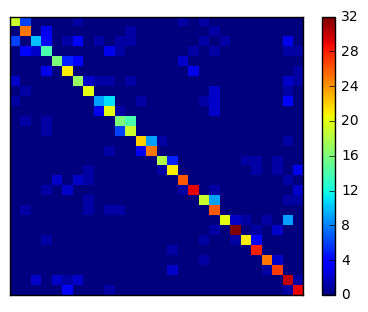

In [94]:
classes28 = ['Grab 1','Grab 2','Tap 1','Tap 2','Expand 1','Expand 2','Pinch 1','Pinch 2','Rotation + 1','Rotation + 2','Rotation - 1','Rotation - 2',
             'Swipe Right 1','Swipe Right 2','Swipe Left 1','Swipe Left 2','Swipe Up 1','Swipe Up 2','Swipe Down 1','Swipe Down 2','Swipe X 1','Swipe X 2','Swipe + 1','Swipe + 2','Swipe V 1','Swipe V 2','Shake 1','Shake 2']
plt.figure(figsize = (5,4))
plot_confusion_matrix(hist, classes=classes28, normalize=False,
                      title='Confusion matrix',cmap=plt.cm.jet, notext=True)
plt.xticks([])
plt.yticks([])
plt.show()

## convert 28 to 14

In [10]:
cl28tocl14 = np.zeros(840,dtype=np.uint8)
for idx,cl_28 in enumerate(results['label_found_28']):
    cl_14 = int((float(cl_28-(cl_28%2)))/2)
    #print(cl_28,'becomes',cl_14)
    cl28tocl14[idx]=cl_14

In [95]:
hist = fast_hist(np.asarray(results['label_gt']),cl28tocl14,14)
acc = np.diag(hist).sum() / hist.sum()
# per-class accuracy
pc_acc = np.diag(hist) / hist.sum(1)
mean_accuracy= np.nanmean(pc_acc)

print("Accuracy:",acc)
print("pc_acc:",pc_acc)
print("mean_accuracy:",mean_accuracy)

Accuracy: 0.828571428571
pc_acc: [ 0.86  0.49  0.76  0.76  0.78  0.95  0.95  0.83  0.82  0.89  0.78  0.93
  0.95  0.84]
mean_accuracy: 0.82873968868


Normalized confusion matrix


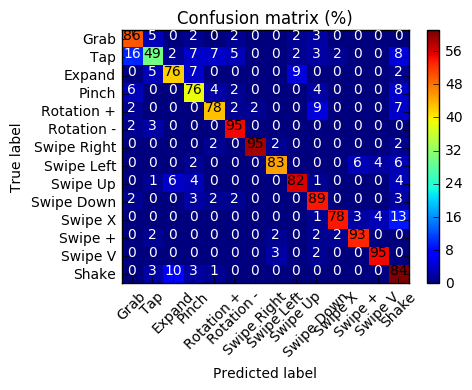

In [99]:
classes14 = ['Grab','Tap','Expand','Pinch','Rotation +','Rotation -',
             'Swipe Right','Swipe Left','Swipe Up','Swipe Down','Swipe X','Swipe +','Swipe V','Shake']
plt.figure(figsize = (5,4))
plot_confusion_matrix(hist, classes=classes14,cmap=plt.cm.jet, normalize=True,title='Confusion matrix (%)')
plt.show()

In [12]:
print("Mean time per sequence :",int(round(np.mean(results['time_millisecond']))),'ms')

Mean time per sequence : 236 ms


## Sauvegarde des fichiers resultats

#### id_gesture     id_finger    id_subject    id_essai    label_found    time_millisecond

In [16]:
resultsfile14 = open('/home/jguerry/workspace/SHRECmodels/results14.txt','w+')
resultsfile28 = open('/home/jguerry/workspace/SHRECmodels/results28.txt','w+')
readmefiles = open('/home/jguerry/workspace/SHRECmodels/readme.txt','w+')

In [17]:
for idx in log_progress(range(net.layers[0].nb_images), title='iteration', end_msg='Finished !',removeAtTheEnd=True):
    
    id_gesture = results['id_gesture'][idx]
    id_finger = results['id_finger'][idx]
    id_subject = results['id_subject'][idx]
    id_essai = results['id_essai'][idx]
    label_found_28 = results['label_found_28'][idx]+1
    label_found_14 = cl28tocl14[idx]+1
    time_millisecond = results['time_millisecond'][idx]
    
    
    print(id_gesture,id_finger,id_subject,id_essai,label_found_14,time_millisecond, file=resultsfile14)
    print(id_gesture,id_finger,id_subject,id_essai,label_found_28,time_millisecond, file=resultsfile28)
print("\
       +-----------------------------------------------------------------------------+\n\
       |  GeForce GTX 1070   Driver Version: 375.26   8112MiB                        |\n\
       +-----------------------------------------------------------------------------+\n\
       |  Intel(R) Xeon(R) CPU E5-1620 v4 @ 3.50GHz                                  |\n\
       |  32GB RAM                                                                   |\n\
       +-----------------------------------------------------------------------------+\n\
", file=readmefiles)

In [18]:
resultsfile14.close()
resultsfile28.close()
readmefiles.close()